# Setup

In [3]:
%%bash 
if [ -d /content/ ]; then
if [ -d itps_voice_recognition ]; then
  cd itps_voice_recognition
  git pull -r 
  cd ..
else 
  git clone https://github.com/iTPS-Inc/itps_voice_recognition.git
fi

if [ ! -f installed ]; then 
pip install datasets==1.13.3
pip install transformers==4.11.3
pip install librosa
pip install jiwer
pip install sentencepiece
pip install -Uqq fastai 
touch installed
fi
fi

In [4]:
import os
if os.path.exists("/content/"):
    os.chdir("itps_voice_recognition")
    from dsets.dsets import ENGLISH_DATASETS, get_datasets
    from dsets.dset_config.dset_config import DatasetConfig

    from dsets.helpers.helpers import apply_parallel, get_sampling_rates
    from itpsaudio.transforms import * 
    from itpsaudio.core import * 
    os.chdir("..")
else:
    from dsets.dsets import ENGLISH_DATASETS, get_datasets
    from dsets.dset_config.dset_config import DatasetConfig
    from dsets.helpers.helpers import apply_parallel, get_sampling_rates
    from itpsaudio.transforms import * 
    from itpsaudio.core import * 

# Imports 

In [5]:
from fastai.data.all import * 
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForMaskedLM, AutoTokenizer, Wav2Vec2Processor, Wav2Vec2ForCTC
from fastai.text.all import * 
from fastai.vision.all import *
from fastai.callback.tensorboard import *
import torchaudio
import pandas
from pathlib import Path
from IPython.display import Audio, display
from datasets import load_metric
wer_metric = load_metric("wer")
dset_lengths = None

In [6]:
ljl = DatasetConfig(name="ljl", split="both")
itps_en = DatasetConfig(name="itps", split="train",lang="en")
p, df = get_datasets([itps_en], force_download=False)

In [7]:
# p, df = get_datasets(ENGLISH_DATASETS, force_download=False)

# Model Training

In [8]:
def get_audio_length(s):
    t, sr = torchaudio.load(s)
    return len(t[0])/sr

In [9]:
df["audio_length"] = apply_parallel(df["filename"], get_audio_length, 4)

100%|███████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]


In [10]:
df = df[df["audio_length"]<15].reset_index(drop=True)
df = df[~df["text"].isna()].reset_index(drop=True)

In [13]:
from transformers import HubertForCTC
pretrained_model_name = "facebook/hubert-large-ls960-ft"
model = HubertForCTC.from_pretrained(pretrained_model_name)
processor = Wav2Vec2Processor.from_pretrained(pretrained_model_name)

dataroot=Path("/")
splits=RandomSplitter(valid_pct=0.2)(df)

y_tfms = [ItemGetter("text"), capitalize, TransformersTokenizer(processor)]
x_tfms = [ItemGetter("filename"),LoadAudio(path=dataroot), extract_first]
if not dset_lengths:
    length_pipeline = Pipeline([LoadAudio(path=dataroot)] + [len])
    train_text_lens = L(df.iloc[splits[0]]["filename"].to_list())
    valid_text_lens = L(df.iloc[splits[1]]["filename"].to_list())
    train_text_lens = train_text_lens.map(length_pipeline)
    valid_text_lens = valid_text_lens.map(length_pipeline)
    dset_lengths = True

dsets = Datasets(df, [x_tfms, y_tfms], n_inp=1, splits=splits)

model = HubertForCTC.from_pretrained(
    pretrained_model_name,
    # Path("/content/drive/MyDrive/data/models/english/librivox/librispeech_en_960hbase"),
    # attention_dropout=0.08,
    # hidden_dropout=0.08,
    # feat_proj_dropout=0.08,
    # mask_time_prob=0.05,
    # layerdrop=0.08,
    # ctc_loss_reduction="mean", 
    ctc_zero_infinity=True,
    # pad_token_id=processor.tokenizer.pad_token_id,
    # vocab_size=len(processor.tokenizer),
).cuda()
model.freeze_feature_extractor()

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/212 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/138 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

/home/jjs/.conda/envs/itps-env/lib/python3.7/site-packages/transformers/models/hubert/modeling_hubert.py:1098: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5.Please use the equivalent `freeze_feature_encoder` method instead.
  FutureWarning,


In [1]:
srtd_dl=partial(SortedDL, res = train_text_lens)
dl_kwargs = [{},{'val_res': valid_text_lens}]

dls = dsets.dataloaders(bs=2,
                        before_batch=[Pad_Audio_Chunk(pad_idx=processor.tokenizer.pad_token_id, seq_len=1)],
                        shuffle=True,
                        sort_func=length_pipeline,
                        dl_kwargs=dl_kwargs,
                        dl_type=srtd_dl)

NameError: name 'partial' is not defined

In [ ]:
def wer(pred, labels):
    pred_logits = pred.logits
    pred_ids = np.argmax(pred_logits.cpu().numpy(), axis=-1)
    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(labels, group_tokens=False)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    return wer

class TransformersLearner(Learner):
    def _do_one_batch(self):
        self.pred = self.model(*self.xb, labels=self.yb[0])
        self('after_pred')
        self.loss_grad = self.pred["loss"]
        self.loss = self.loss_grad.clone()
        self.smooth_loss = self.loss_grad.clone()
        self('after_loss')
        if not self.training or not len(self.yb): return
        self('before_backward')
        self.loss_grad.backward()
        self._with_events(self.opt.step, 'step', CancelStepException)
        self.opt.zero_grad()

In [ ]:
x, y = dls.one_batch()

In [ ]:
processor.batch_decode(dls.one_batch()[1])

["<unk> AND THAT<unk>FS THE LAST OF THE CURENT MEMBERSHIP TO THE OECD SE SO THERE'S AN AWFUL LOT OF OF COUNTRIES THERE",
 'THE FIXED RETURN WOULD CONSIDER DIFERENCES AND REGIONAL IN INDUSTRY AND TREATY CHANGES WIL NOT BE REQUIRED TO IMPLEMENT AMOUNT B']

In [ ]:
logdir = Path("/content/drive/MyDrive/data/logs/audio_en/wav2vec2")
modelpath=Path("/content/drive/MyDrive/data/models/")
cbs=[TensorBoardCallback(log_dir=logdir,trace_model=False,log_preds=False),
     SaveModelCallback(fname=Path(modelpath/ "audio_en"/"wav2vec2")), 
     EarlyStoppingCallback(patience=10)]

learn = TransformersLearner(dls, model,
                loss_func=noop, # Loss is calculated in Transformers internally
                metrics=[Perplexity(), wer ],
                cbs=cbs)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

2401

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


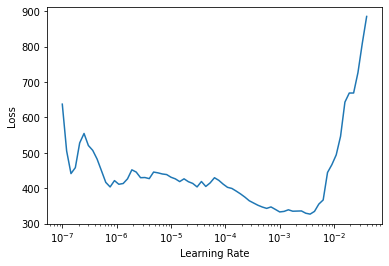

In [ ]:
start_lr=1e-7
end_lr=10
r = learn.lr_find(start_lr=start_lr, end_lr=end_lr, num_it=100, stop_div=True, suggest_funcs=())

In [ ]:
learn.fine_tune(100, 2e-4, 50)

epoch,train_loss,valid_loss,perplexity,wer,time
0,240.547012,202.082779,inf,0.576132,05:30
1,212.139771,172.517365,inf,0.558528,03:56
2,189.925903,164.425095,inf,0.552270,03:42
3,194.459442,161.841492,inf,0.549975,03:31
4,175.179108,155.433929,inf,0.528069,03:24
5,165.354019,147.900497,inf,0.513570,03:26
6,159.788620,144.854233,inf,0.481534,03:25
7,153.044678,149.233627,inf,0.494128,03:22
8,141.611374,153.410583,inf,0.491739,03:19
9,137.458649,144.597092,inf,0.487393,03:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with valid_loss value: 202.08277893066406.
Better model found at epoch 1 with valid_loss value: 172.51736450195312.
Better model found at epoch 2 with valid_loss value: 164.4250946044922.
Better model found at epoch 3 with valid_loss value: 161.84149169921875.
Better model found at epoch 4 with valid_loss value: 155.43392944335938.
Better model found at epoch 5 with valid_loss value: 147.90049743652344.
Better model found at epoch 6 with valid_loss value: 144.85423278808594.
Better model found at epoch 9 with valid_loss value: 144.5970916748047.
No improvement since epoch 9: early stopping


epoch,train_loss,valid_loss,perplexity,wer,time
0,136.040100,150.449020,inf,0.467810,03:16
1,110.261246,154.992493,inf,0.469043,03:17
2,106.218063,156.131042,inf,0.446609,03:15
3,93.387985,153.925964,inf,0.452413,03:16
4,108.378731,164.069565,inf,0.463365,03:16
5,103.795944,159.588501,inf,0.464202,03:17
6,88.529099,151.630447,inf,0.455235,03:17
7,91.642517,149.165527,inf,0.441046,03:16
8,85.354721,150.881882,inf,0.440043,03:16
9,81.406738,171.323380,inf,0.447527,03:15


Better model found at epoch 0 with valid_loss value: 150.4490203857422.
Better model found at epoch 7 with valid_loss value: 149.16552734375.
No improvement since epoch 7: early stopping


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


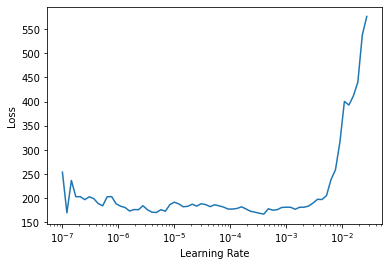

In [ ]:
start_lr=1e-7
end_lr=10
r = learn.lr_find(start_lr=start_lr, end_lr=end_lr, num_it=100, stop_div=True, suggest_funcs=())

In [ ]:
learn.fine_tune(10, 3e-4, freeze_epochs=5)

epoch,train_loss,valid_loss,perplexity,wer,time
0,nan,nan,nan,1.000000,03:37


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
from datasets import load_dataset
import soundfile as sf

librispeech_eval = load_dataset("librispeech_asr", "clean", split="test")

def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

librispeech_eval = librispeech_eval.map(map_to_array)

def map_to_pred(batch):
    input_values = processor(batch["speech"], return_tensors="pt", padding="longest", sampling_rate=16000).input_values
    with torch.no_grad():
        logits = model(input_values.to("cuda")).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    batch["transcription"] = transcription
    return batch
result = librispeech_eval.map(map_to_pred, batched=True, batch_size=1, remove_columns=["speech"])
print("WER:", wer_metric.compute(references=result["text"],
                                  predictions=result["transcription"]))

Reusing dataset librispeech_asr (/root/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/f58a17d82b157feddbc407342a657fee7389b87c33d8331312edf7a604392896)
Loading cached processed dataset at /root/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/f58a17d82b157feddbc407342a657fee7389b87c33d8331312edf7a604392896/cache-51d64dc0006a1d73.arrow


  0%|          | 0/2620 [00:00<?, ?ba/s]

WER: 0.02076993304930006
